# GPU Version to run on MARCC

This notebook is assummed to be launched from the top level of the AutomaticLP github repo (where the notebook file is)

This also assummes that you've already cloed the tensorflow object detection project
https://github.com/tensorflow/models (since you need to do this to add the python path to  the bashrc file which has to be done before launching jupyter lab

Run with the LPproject kernel

## Setup / Installations

Add
<code>
export PYTHONPATH=$PYTHONPATH:`pwd`
export PYTHONPATH=$PYTHONPATH:`pwd`/slim

to your ~/.bashrc file where pwd is the full path to the models/research directory

### Tests that Tensorflow GPU is installed & this notebook can see the GPU 

These don't need to be run everytime but are here as a sanity / debugging check

In [ ]:
# test that tensorflow can access a GPU
import tensorflow as tf
tf.test.is_built_with_cuda()

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
print ('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


In [ ]:
%%bash 
cd models/research
FILE=protobuf.zip
if [ ! -f "$FILE" ]; then
    wget -O protobuf.zip https://github.com/google/protobuf/releases/download/v3.0.0/protoc-3.0.0-linux-x86_64.zip
    unzip protobuf.zip
fi
./bin/protoc object_detection/protos/*.proto --python_out=.
pip install --user .

In [ ]:
!ml cuda/9.0
!export CUDA_VISIBLE_DEVICES=1
!echo ${CUDA_VISIBLE_DEVICES}

## Generating Datasets

The ScriptForBashFile generates both the training and test data and TFRecords from the image files


In [ ]:
%run ScriptForBashFile

## Train


In [ ]:
# If training output directory dosen't exist create it
!mkdir -p trainingOutput

In [ ]:
# This makes the output of the next cell write to the file
# https://stackoverflow.com/questions/45200375/stdout-redirect-from-jupyter-notebook-is-landing-in-the-terminal
import sys
old_stdout = sys.stdout
sys.stdout = open('trainingLog.txt', 'w')

In [ ]:
%cd models/research
%run object_detection/legacy/train.py --logtostderr --train_dir=../../trainingOutput/ --pipeline_config_path=../../FromScratch/models/model/ssd_mobilenet_v1_coco.config 
%cd ../..

In [ ]:
# Put the cell output back to normal
sys.stdout = old_stdout

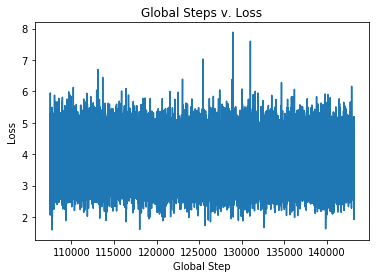

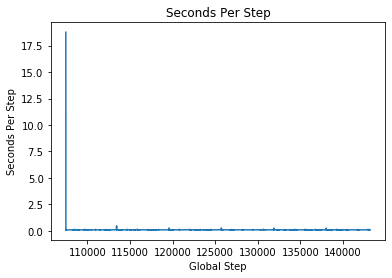

In [1]:
%matplotlib inline
%run viewTraining.py

## Evaluation



In [1]:
# We want to run Evaluation on the latest checkpoint 
# this code extracts the step number of the most recent checkpoint saved

from os import listdir
import re

%cd trainingOutput
checkpointList = listdir()
%cd ..

numbers = []
for filename in checkpointList:
    match = re.search("^model.ckpt-", filename)
    if not match is None:
        filename = filename.split(".")
        filename = filename[1].split("-")
        numbers.append(filename[1])

lastCheckpoint = max(numbers)
print(lastCheckpoint)
CHECKPOINT_PREFIX = "../../trainingOutput/model.ckpt-"+str(lastCheckpoint)

/home/christina/Documents/Thesis/AutomaticLP/trainingOutput
/home/christina/Documents/Thesis/AutomaticLP
138045


In [2]:
%cd models/research
%run object_detection/export_inference_graph.py --input_type image_tensor --pipeline_config_path ../../FromScratch/models/model/ssd_mobilenet_v1_coco.config --trained_checkpoint_prefix $CHECKPOINT_PREFIX --output_directory ../../inference_graph
%cd ../..

/home/christina/Documents/Thesis/AutomaticLP/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0418 09:00:37.252620 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



W0418 09:00:37.265713 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



W0418 09:00:37.267987 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



W0418 09:00:37.329966 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/core/preprocessor.py:2937: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.



W0418 09:00:37.371114 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/meta_architectures/ssd_meta_arch.py:589: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



W0418 09:00:37.372540 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/meta_architectures/ssd_meta_arch.py:597: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Instructions for updating:
Please use `layer.__call__` method instead.


W0418 09:00:37.377856 140261990434624 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1057: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0418 09:00:38.954887 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/core/anchor_generator.py:171: The name tf.assert_equal is deprecated. Please use tf.compat.v1.assert_equal instead.



W0418 09:00:38.974032 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/predictors/convolutional_box_predictor.py:150: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:depth of additional conv before box predictor: 0


I0418 09:00:38.975942 140261990434624 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0418 09:00:39.031231 140261990434624 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0418 09:00:39.080400 140261990434624 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0418 09:00:39.129656 140261990434624 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0418 09:00:39.179512 140261990434624 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


I0418 09:00:39.230016 140261990434624 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0418 09:00:39.500621 140261990434624 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/core/post_processing.py:581: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0418 09:00:41.309757 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:278: The name tf.add_to_collection is deprecated. Please use tf.compat.v1.add_to_collection instead.



Instructions for updating:
Please switch to tf.train.get_or_create_global_step


W0418 09:00:41.311031 140261990434624 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:383: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step


W0418 09:00:41.318571 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:415: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details


W0418 09:00:41.321966 140261990434624 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:539: print_model_analysis (from tensorflow.contrib.tfprof.model_analyzer) is deprecated and will be removed after 2018-01-01.
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


W0418 09:00:41.325538 140261990434624 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/profiler/internal/flops_registry.py:142: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
170 ops no flops stats due to incomplete shapes.
170 ops no flops stats due to incomplete shapes.


W0418 09:00:42.837006 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:432: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



W0418 09:00:43.974952 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:342: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



INFO:tensorflow:Restoring parameters from ../../trainingOutput/model.ckpt-138045


I0418 09:00:44.027008 140261990434624 saver.py:1284] Restoring parameters from ../../trainingOutput/model.ckpt-138045


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0418 09:00:45.691629 140261990434624 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ../../trainingOutput/model.ckpt-138045


I0418 09:00:46.571647 140261990434624 saver.py:1284] Restoring parameters from ../../trainingOutput/model.ckpt-138045


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


W0418 09:00:47.436578 140261990434624 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/tools/freeze_graph.py:233: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


W0418 09:00:47.437725 140261990434624 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/graph_util_impl.py:277: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Froze 199 variables.


I0418 09:00:47.962359 140261990434624 graph_util_impl.py:334] Froze 199 variables.


INFO:tensorflow:Converted 199 variables to const ops.


I0418 09:00:48.050736 140261990434624 graph_util_impl.py:394] Converted 199 variables to const ops.


W0418 09:00:49.086524 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:306: The name tf.saved_model.builder.SavedModelBuilder is deprecated. Please use tf.compat.v1.saved_model.builder.SavedModelBuilder instead.



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0418 09:00:49.088386 140261990434624 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:309: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0418 09:00:49.090237 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:315: The name tf.saved_model.signature_def_utils.build_signature_def is deprecated. Please use tf.compat.v1.saved_model.signature_def_utils.build_signature_def instead.



W0418 09:00:49.091590 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:318: The name tf.saved_model.signature_constants.PREDICT_METHOD_NAME is deprecated. Please use tf.saved_model.PREDICT_METHOD_NAME instead.



W0418 09:00:49.093378 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:323: The name tf.saved_model.tag_constants.SERVING is deprecated. Please use tf.saved_model.SERVING instead.



W0418 09:00:49.094759 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/exporter.py:325: The name tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY is deprecated. Please use tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY instead.



INFO:tensorflow:No assets to save.


I0418 09:00:49.102025 140261990434624 builder_impl.py:640] No assets to save.


INFO:tensorflow:No assets to write.


I0418 09:00:49.106836 140261990434624 builder_impl.py:460] No assets to write.


INFO:tensorflow:SavedModel written to: ../../inference_graph/saved_model/saved_model.pb


I0418 09:00:49.722843 140261990434624 builder_impl.py:425] SavedModel written to: ../../inference_graph/saved_model/saved_model.pb


W0418 09:00:49.781132 140261990434624 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/utils/config_util.py:188: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



INFO:tensorflow:Writing pipeline config file to ../../inference_graph/pipeline.config


I0418 09:00:49.782360 140261990434624 config_util.py:190] Writing pipeline config file to ../../inference_graph/pipeline.config


/home/christina/Documents/Thesis/AutomaticLP


In [ ]:
%matplotlib inline
import matplotlib as plt


%run customEvaluation.py




Enter Test Image Directory Name: TestImages_2020-04-11_11-49
Enter Threshold (0-1) for object detection: .5


/home/christina/Documents/Thesis/AutomaticLP/customEvaluation.py:81: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [2]:
%cd models/research
%run object_detection/inference/infer_detections.py --input_tfrecord_paths=../../FromScratch/TFRecordEval.tfrecord --inference_graph=../../inference_graph/frozen_inference_graph.pb --output_tfrecord_path=../../TFExamples.tfrecord
%cd ../..

/home/christina/Documents/Thesis/AutomaticLP/models/research




W0415 19:06:40.739892 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:57: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.



W0415 19:06:40.741791 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:57: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.



W0415 19:06:40.745978 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:68: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



INFO:tensorflow:Reading input from 1 files


I0415 19:06:40.747815 139791388702528 infer_detections.py:68] Reading input from 1 files


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


W0415 19:06:40.750152 139791388702528 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:35: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


W0415 19:06:40.762965 139791388702528 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:277: input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


W0415 19:06:40.768691 139791388702528 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:189: limit_epochs (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


Instructions for updating:
Prefer Dataset.range instead.


W0415 19:06:40.778903 139791388702528 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:112: RefVariable.count_up_to (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Dataset.range instead.


Instructions for updating:
Prefer Dataset.range instead.


W0415 19:06:40.780141 139791388702528 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:2522: count_up_to (from tensorflow.python.ops.state_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Dataset.range instead.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0415 19:06:40.798810 139791388702528 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:198: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0415 19:06:40.809206 139791388702528 deprecation.py:323] From /home/christina/.local/lib/python3.7/site-packages/tensorflow_core/python/training/input.py:198: add_queue_runner (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


W0415 19:06:40.819192 139791388702528 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:37: TFRecordReader.__init__ (from tensorflow.python.ops.io_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


W0415 19:06:40.827430 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:39: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.



W0415 19:06:40.829527 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:43: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



INFO:tensorflow:Reading graph and building model...


I0415 19:06:40.921840 139791388702528 infer_detections.py:71] Reading graph and building model...


W0415 19:06:40.924013 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:68: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



W0415 19:06:41.601196 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:76: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



INFO:tensorflow:Running inference and writing output to ../../TFExamples.tfrecord


I0415 19:06:41.625770 139791388702528 infer_detections.py:77] Running inference and writing output to ../../TFExamples.tfrecord


W0415 19:06:41.627375 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:78: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.



Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0415 19:06:41.798329 139791388702528 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:79: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0415 19:06:41.800688 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:80: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



W0415 19:06:41.802703 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/infer_detections.py:84: The name tf.logging.log_every_n is deprecated. Please use tf.compat.v1.logging.log_every_n instead.



INFO:tensorflow:Processed 0 images...


I0415 19:06:41.803900 139791388702528 infer_detections.py:85] Processed 0 images...


W0415 19:06:41.805596 139791388702528 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/inference/detection_inference.py:117: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



INFO:tensorflow:Processed 10 images...


I0415 19:06:43.335597 139791388702528 infer_detections.py:85] Processed 10 images...


INFO:tensorflow:Processed 20 images...


I0415 19:06:43.630374 139791388702528 infer_detections.py:85] Processed 20 images...


INFO:tensorflow:Processed 30 images...


I0415 19:06:43.900218 139791388702528 infer_detections.py:85] Processed 30 images...


INFO:tensorflow:Processed 40 images...


I0415 19:06:44.125858 139791388702528 infer_detections.py:85] Processed 40 images...


INFO:tensorflow:Processed 50 images...


I0415 19:06:44.291224 139791388702528 infer_detections.py:85] Processed 50 images...


INFO:tensorflow:Processed 60 images...


I0415 19:06:44.453879 139791388702528 infer_detections.py:85] Processed 60 images...


INFO:tensorflow:Processed 70 images...


I0415 19:06:44.595356 139791388702528 infer_detections.py:85] Processed 70 images...


INFO:tensorflow:Processed 80 images...


I0415 19:06:44.754535 139791388702528 infer_detections.py:85] Processed 80 images...


INFO:tensorflow:Processed 90 images...


I0415 19:06:44.909024 139791388702528 infer_detections.py:85] Processed 90 images...


INFO:tensorflow:Processed 100 images...


I0415 19:06:45.069705 139791388702528 infer_detections.py:85] Processed 100 images...


INFO:tensorflow:Processed 110 images...


I0415 19:06:45.224150 139791388702528 infer_detections.py:85] Processed 110 images...


INFO:tensorflow:Processed 120 images...


I0415 19:06:45.368361 139791388702528 infer_detections.py:85] Processed 120 images...


INFO:tensorflow:Processed 130 images...


I0415 19:06:45.512202 139791388702528 infer_detections.py:85] Processed 130 images...


INFO:tensorflow:Processed 140 images...


I0415 19:06:45.662589 139791388702528 infer_detections.py:85] Processed 140 images...


INFO:tensorflow:Processed 150 images...


I0415 19:06:45.807854 139791388702528 infer_detections.py:85] Processed 150 images...


INFO:tensorflow:Processed 160 images...


I0415 19:06:45.951556 139791388702528 infer_detections.py:85] Processed 160 images...


INFO:tensorflow:Processed 170 images...


I0415 19:06:46.096864 139791388702528 infer_detections.py:85] Processed 170 images...


INFO:tensorflow:Processed 180 images...


I0415 19:06:46.239036 139791388702528 infer_detections.py:85] Processed 180 images...


INFO:tensorflow:Processed 190 images...


I0415 19:06:46.381213 139791388702528 infer_detections.py:85] Processed 190 images...


INFO:tensorflow:Processed 200 images...


I0415 19:06:46.521366 139791388702528 infer_detections.py:85] Processed 200 images...


INFO:tensorflow:Processed 210 images...


I0415 19:06:46.660629 139791388702528 infer_detections.py:85] Processed 210 images...


INFO:tensorflow:Processed 220 images...


I0415 19:06:46.803452 139791388702528 infer_detections.py:85] Processed 220 images...


INFO:tensorflow:Processed 230 images...


I0415 19:06:46.943851 139791388702528 infer_detections.py:85] Processed 230 images...


INFO:tensorflow:Processed 240 images...


I0415 19:06:47.090124 139791388702528 infer_detections.py:85] Processed 240 images...


INFO:tensorflow:Processed 250 images...


I0415 19:06:47.231600 139791388702528 infer_detections.py:85] Processed 250 images...


INFO:tensorflow:Processed 260 images...


I0415 19:06:47.375220 139791388702528 infer_detections.py:85] Processed 260 images...


INFO:tensorflow:Processed 270 images...


I0415 19:06:47.514571 139791388702528 infer_detections.py:85] Processed 270 images...


INFO:tensorflow:Processed 280 images...


I0415 19:06:47.652890 139791388702528 infer_detections.py:85] Processed 280 images...


INFO:tensorflow:Processed 290 images...


I0415 19:06:47.793854 139791388702528 infer_detections.py:85] Processed 290 images...


INFO:tensorflow:Processed 300 images...


I0415 19:06:47.932444 139791388702528 infer_detections.py:85] Processed 300 images...


INFO:tensorflow:Processed 310 images...


I0415 19:06:48.076151 139791388702528 infer_detections.py:85] Processed 310 images...


INFO:tensorflow:Processed 320 images...


I0415 19:06:48.214922 139791388702528 infer_detections.py:85] Processed 320 images...


INFO:tensorflow:Processed 330 images...


I0415 19:06:48.353713 139791388702528 infer_detections.py:85] Processed 330 images...


INFO:tensorflow:Processed 340 images...


I0415 19:06:48.495131 139791388702528 infer_detections.py:85] Processed 340 images...


INFO:tensorflow:Processed 350 images...


I0415 19:06:48.654501 139791388702528 infer_detections.py:85] Processed 350 images...


INFO:tensorflow:Processed 360 images...


I0415 19:06:48.857192 139791388702528 infer_detections.py:85] Processed 360 images...


INFO:tensorflow:Processed 370 images...


I0415 19:06:49.019346 139791388702528 infer_detections.py:85] Processed 370 images...


INFO:tensorflow:Processed 380 images...


I0415 19:06:49.161370 139791388702528 infer_detections.py:85] Processed 380 images...


INFO:tensorflow:Processed 390 images...


I0415 19:06:49.305827 139791388702528 infer_detections.py:85] Processed 390 images...


INFO:tensorflow:Processed 400 images...


I0415 19:06:49.446901 139791388702528 infer_detections.py:85] Processed 400 images...


INFO:tensorflow:Processed 410 images...


I0415 19:06:49.587711 139791388702528 infer_detections.py:85] Processed 410 images...


INFO:tensorflow:Processed 420 images...


I0415 19:06:49.729876 139791388702528 infer_detections.py:85] Processed 420 images...


INFO:tensorflow:Processed 430 images...


I0415 19:06:49.868537 139791388702528 infer_detections.py:85] Processed 430 images...


INFO:tensorflow:Processed 440 images...


I0415 19:06:50.009619 139791388702528 infer_detections.py:85] Processed 440 images...


INFO:tensorflow:Processed 450 images...


I0415 19:06:50.148186 139791388702528 infer_detections.py:85] Processed 450 images...


INFO:tensorflow:Processed 460 images...


I0415 19:06:50.287031 139791388702528 infer_detections.py:85] Processed 460 images...


INFO:tensorflow:Processed 470 images...


I0415 19:06:50.428306 139791388702528 infer_detections.py:85] Processed 470 images...


INFO:tensorflow:Processed 480 images...


I0415 19:06:50.569045 139791388702528 infer_detections.py:85] Processed 480 images...


INFO:tensorflow:Processed 490 images...


I0415 19:06:50.711599 139791388702528 infer_detections.py:85] Processed 490 images...


INFO:tensorflow:Processed 500 images...


I0415 19:06:50.851858 139791388702528 infer_detections.py:85] Processed 500 images...


INFO:tensorflow:Processed 510 images...


I0415 19:06:50.995937 139791388702528 infer_detections.py:85] Processed 510 images...


INFO:tensorflow:Processed 520 images...


I0415 19:06:51.135566 139791388702528 infer_detections.py:85] Processed 520 images...


INFO:tensorflow:Processed 530 images...


I0415 19:06:51.273725 139791388702528 infer_detections.py:85] Processed 530 images...


INFO:tensorflow:Processed 540 images...


I0415 19:06:51.411771 139791388702528 infer_detections.py:85] Processed 540 images...


INFO:tensorflow:Processed 550 images...


I0415 19:06:51.552181 139791388702528 infer_detections.py:85] Processed 550 images...


INFO:tensorflow:Processed 560 images...


I0415 19:06:51.691407 139791388702528 infer_detections.py:85] Processed 560 images...


INFO:tensorflow:Processed 570 images...


I0415 19:06:51.829584 139791388702528 infer_detections.py:85] Processed 570 images...


INFO:tensorflow:Processed 580 images...


I0415 19:06:51.967406 139791388702528 infer_detections.py:85] Processed 580 images...


INFO:tensorflow:Processed 590 images...


I0415 19:06:52.104680 139791388702528 infer_detections.py:85] Processed 590 images...


INFO:tensorflow:Processed 600 images...


I0415 19:06:52.243413 139791388702528 infer_detections.py:85] Processed 600 images...


INFO:tensorflow:Processed 610 images...


I0415 19:06:52.386348 139791388702528 infer_detections.py:85] Processed 610 images...


INFO:tensorflow:Processed 620 images...


I0415 19:06:52.527245 139791388702528 infer_detections.py:85] Processed 620 images...


INFO:tensorflow:Processed 630 images...


I0415 19:06:52.664257 139791388702528 infer_detections.py:85] Processed 630 images...


INFO:tensorflow:Processed 640 images...


I0415 19:06:52.805284 139791388702528 infer_detections.py:85] Processed 640 images...


INFO:tensorflow:Processed 650 images...


I0415 19:06:52.998841 139791388702528 infer_detections.py:85] Processed 650 images...


INFO:tensorflow:Processed 660 images...


I0415 19:06:53.140973 139791388702528 infer_detections.py:85] Processed 660 images...


INFO:tensorflow:Processed 670 images...


I0415 19:06:53.281085 139791388702528 infer_detections.py:85] Processed 670 images...


INFO:tensorflow:Processed 680 images...


I0415 19:06:53.417848 139791388702528 infer_detections.py:85] Processed 680 images...


INFO:tensorflow:Processed 690 images...


I0415 19:06:53.564320 139791388702528 infer_detections.py:85] Processed 690 images...


INFO:tensorflow:Processed 700 images...


I0415 19:06:53.709588 139791388702528 infer_detections.py:85] Processed 700 images...


INFO:tensorflow:Processed 710 images...


I0415 19:06:53.851317 139791388702528 infer_detections.py:85] Processed 710 images...


INFO:tensorflow:Processed 720 images...


I0415 19:06:53.993295 139791388702528 infer_detections.py:85] Processed 720 images...


INFO:tensorflow:Processed 730 images...


I0415 19:06:54.134876 139791388702528 infer_detections.py:85] Processed 730 images...


INFO:tensorflow:Processed 740 images...


I0415 19:06:54.275836 139791388702528 infer_detections.py:85] Processed 740 images...


INFO:tensorflow:Processed 750 images...


I0415 19:06:54.419078 139791388702528 infer_detections.py:85] Processed 750 images...


INFO:tensorflow:Processed 760 images...


I0415 19:06:54.561161 139791388702528 infer_detections.py:85] Processed 760 images...


INFO:tensorflow:Processed 770 images...


I0415 19:06:54.702576 139791388702528 infer_detections.py:85] Processed 770 images...


INFO:tensorflow:Processed 780 images...


I0415 19:06:54.845585 139791388702528 infer_detections.py:85] Processed 780 images...


INFO:tensorflow:Processed 790 images...


I0415 19:06:54.989196 139791388702528 infer_detections.py:85] Processed 790 images...


INFO:tensorflow:Processed 800 images...


I0415 19:06:55.132034 139791388702528 infer_detections.py:85] Processed 800 images...


INFO:tensorflow:Processed 810 images...


I0415 19:06:55.271914 139791388702528 infer_detections.py:85] Processed 810 images...


INFO:tensorflow:Processed 820 images...


I0415 19:06:55.417816 139791388702528 infer_detections.py:85] Processed 820 images...


INFO:tensorflow:Processed 830 images...


I0415 19:06:55.554781 139791388702528 infer_detections.py:85] Processed 830 images...


INFO:tensorflow:Processed 840 images...


I0415 19:06:55.712010 139791388702528 infer_detections.py:85] Processed 840 images...


INFO:tensorflow:Processed 850 images...


I0415 19:06:55.853443 139791388702528 infer_detections.py:85] Processed 850 images...


INFO:tensorflow:Processed 860 images...


I0415 19:06:55.998591 139791388702528 infer_detections.py:85] Processed 860 images...


INFO:tensorflow:Processed 870 images...


I0415 19:06:56.135470 139791388702528 infer_detections.py:85] Processed 870 images...


INFO:tensorflow:Processed 880 images...


I0415 19:06:56.277071 139791388702528 infer_detections.py:85] Processed 880 images...


INFO:tensorflow:Processed 890 images...


I0415 19:06:56.417164 139791388702528 infer_detections.py:85] Processed 890 images...


INFO:tensorflow:Processed 900 images...


I0415 19:06:56.559167 139791388702528 infer_detections.py:85] Processed 900 images...


INFO:tensorflow:Processed 910 images...


I0415 19:06:56.700469 139791388702528 infer_detections.py:85] Processed 910 images...


INFO:tensorflow:Processed 920 images...


I0415 19:06:56.841572 139791388702528 infer_detections.py:85] Processed 920 images...


INFO:tensorflow:Processed 930 images...


I0415 19:06:56.984268 139791388702528 infer_detections.py:85] Processed 930 images...


INFO:tensorflow:Processed 940 images...


I0415 19:06:57.121708 139791388702528 infer_detections.py:85] Processed 940 images...


INFO:tensorflow:Processed 950 images...


I0415 19:06:57.259223 139791388702528 infer_detections.py:85] Processed 950 images...


INFO:tensorflow:Processed 960 images...


I0415 19:06:57.399830 139791388702528 infer_detections.py:85] Processed 960 images...


INFO:tensorflow:Processed 970 images...


I0415 19:06:57.540889 139791388702528 infer_detections.py:85] Processed 970 images...


INFO:tensorflow:Processed 980 images...


I0415 19:06:57.682305 139791388702528 infer_detections.py:85] Processed 980 images...


INFO:tensorflow:Processed 990 images...


I0415 19:06:57.823669 139791388702528 infer_detections.py:85] Processed 990 images...


INFO:tensorflow:Processed 1000 images...


I0415 19:06:57.991743 139791388702528 infer_detections.py:85] Processed 1000 images...


INFO:tensorflow:Processed 1010 images...


I0415 19:06:58.155796 139791388702528 infer_detections.py:85] Processed 1010 images...


INFO:tensorflow:Processed 1020 images...


I0415 19:06:58.294424 139791388702528 infer_detections.py:85] Processed 1020 images...


INFO:tensorflow:Processed 1030 images...


I0415 19:06:58.436573 139791388702528 infer_detections.py:85] Processed 1030 images...


INFO:tensorflow:Processed 1040 images...


I0415 19:06:58.576580 139791388702528 infer_detections.py:85] Processed 1040 images...


INFO:tensorflow:Processed 1050 images...


I0415 19:06:58.718911 139791388702528 infer_detections.py:85] Processed 1050 images...


INFO:tensorflow:Processed 1060 images...


I0415 19:06:58.861140 139791388702528 infer_detections.py:85] Processed 1060 images...


INFO:tensorflow:Processed 1070 images...


I0415 19:06:59.004606 139791388702528 infer_detections.py:85] Processed 1070 images...


INFO:tensorflow:Processed 1080 images...


I0415 19:06:59.142308 139791388702528 infer_detections.py:85] Processed 1080 images...


INFO:tensorflow:Processed 1090 images...


I0415 19:06:59.284566 139791388702528 infer_detections.py:85] Processed 1090 images...


INFO:tensorflow:Processed 1100 images...


I0415 19:06:59.423006 139791388702528 infer_detections.py:85] Processed 1100 images...


INFO:tensorflow:Processed 1110 images...


I0415 19:06:59.564735 139791388702528 infer_detections.py:85] Processed 1110 images...


INFO:tensorflow:Processed 1120 images...


I0415 19:06:59.703846 139791388702528 infer_detections.py:85] Processed 1120 images...


INFO:tensorflow:Processed 1130 images...


I0415 19:06:59.845408 139791388702528 infer_detections.py:85] Processed 1130 images...


INFO:tensorflow:Processed 1140 images...


I0415 19:06:59.993052 139791388702528 infer_detections.py:85] Processed 1140 images...


INFO:tensorflow:Processed 1150 images...


I0415 19:07:00.135425 139791388702528 infer_detections.py:85] Processed 1150 images...


INFO:tensorflow:Processed 1160 images...


I0415 19:07:00.275847 139791388702528 infer_detections.py:85] Processed 1160 images...


INFO:tensorflow:Processed 1170 images...


I0415 19:07:00.415779 139791388702528 infer_detections.py:85] Processed 1170 images...


INFO:tensorflow:Processed 1180 images...


I0415 19:07:00.554801 139791388702528 infer_detections.py:85] Processed 1180 images...


INFO:tensorflow:Processed 1190 images...


I0415 19:07:00.693741 139791388702528 infer_detections.py:85] Processed 1190 images...


INFO:tensorflow:Processed 1200 images...


I0415 19:07:00.833122 139791388702528 infer_detections.py:85] Processed 1200 images...


INFO:tensorflow:Processed 1210 images...


I0415 19:07:00.970417 139791388702528 infer_detections.py:85] Processed 1210 images...


INFO:tensorflow:Processed 1220 images...


I0415 19:07:01.108791 139791388702528 infer_detections.py:85] Processed 1220 images...


INFO:tensorflow:Processed 1230 images...


I0415 19:07:01.248536 139791388702528 infer_detections.py:85] Processed 1230 images...


INFO:tensorflow:Processed 1240 images...


I0415 19:07:01.391016 139791388702528 infer_detections.py:85] Processed 1240 images...


INFO:tensorflow:Processed 1250 images...


I0415 19:07:01.534102 139791388702528 infer_detections.py:85] Processed 1250 images...


INFO:tensorflow:Processed 1260 images...


I0415 19:07:01.671720 139791388702528 infer_detections.py:85] Processed 1260 images...


INFO:tensorflow:Processed 1270 images...


I0415 19:07:01.810266 139791388702528 infer_detections.py:85] Processed 1270 images...


INFO:tensorflow:Processed 1280 images...


I0415 19:07:01.950811 139791388702528 infer_detections.py:85] Processed 1280 images...


INFO:tensorflow:Processed 1290 images...


I0415 19:07:02.088116 139791388702528 infer_detections.py:85] Processed 1290 images...


INFO:tensorflow:Processed 1300 images...


I0415 19:07:02.228980 139791388702528 infer_detections.py:85] Processed 1300 images...


INFO:tensorflow:Processed 1310 images...


I0415 19:07:02.369304 139791388702528 infer_detections.py:85] Processed 1310 images...


INFO:tensorflow:Processed 1320 images...


I0415 19:07:02.508637 139791388702528 infer_detections.py:85] Processed 1320 images...


INFO:tensorflow:Processed 1330 images...


I0415 19:07:02.645523 139791388702528 infer_detections.py:85] Processed 1330 images...


INFO:tensorflow:Processed 1340 images...


I0415 19:07:02.783819 139791388702528 infer_detections.py:85] Processed 1340 images...


INFO:tensorflow:Processed 1350 images...


I0415 19:07:02.924654 139791388702528 infer_detections.py:85] Processed 1350 images...


INFO:tensorflow:Processed 1360 images...


I0415 19:07:03.080443 139791388702528 infer_detections.py:85] Processed 1360 images...


INFO:tensorflow:Processed 1370 images...


I0415 19:07:03.256815 139791388702528 infer_detections.py:85] Processed 1370 images...


INFO:tensorflow:Processed 1380 images...


I0415 19:07:03.394576 139791388702528 infer_detections.py:85] Processed 1380 images...


INFO:tensorflow:Processed 1390 images...


I0415 19:07:03.544342 139791388702528 infer_detections.py:85] Processed 1390 images...


INFO:tensorflow:Processed 1400 images...


I0415 19:07:03.683105 139791388702528 infer_detections.py:85] Processed 1400 images...


INFO:tensorflow:Processed 1410 images...


I0415 19:07:03.819437 139791388702528 infer_detections.py:85] Processed 1410 images...


INFO:tensorflow:Processed 1420 images...


I0415 19:07:03.958396 139791388702528 infer_detections.py:85] Processed 1420 images...


INFO:tensorflow:Processed 1430 images...


I0415 19:07:04.100129 139791388702528 infer_detections.py:85] Processed 1430 images...


INFO:tensorflow:Processed 1440 images...


I0415 19:07:04.238155 139791388702528 infer_detections.py:85] Processed 1440 images...


INFO:tensorflow:Processed 1450 images...


I0415 19:07:04.377806 139791388702528 infer_detections.py:85] Processed 1450 images...


INFO:tensorflow:Processed 1460 images...


I0415 19:07:04.517214 139791388702528 infer_detections.py:85] Processed 1460 images...


INFO:tensorflow:Processed 1470 images...


I0415 19:07:04.656790 139791388702528 infer_detections.py:85] Processed 1470 images...


INFO:tensorflow:Processed 1480 images...


I0415 19:07:04.793154 139791388702528 infer_detections.py:85] Processed 1480 images...


INFO:tensorflow:Processed 1490 images...


I0415 19:07:04.930933 139791388702528 infer_detections.py:85] Processed 1490 images...


INFO:tensorflow:Processed 1500 images...


I0415 19:07:05.071224 139791388702528 infer_detections.py:85] Processed 1500 images...


INFO:tensorflow:Processed 1510 images...


I0415 19:07:05.211068 139791388702528 infer_detections.py:85] Processed 1510 images...


INFO:tensorflow:Processed 1520 images...


I0415 19:07:05.352843 139791388702528 infer_detections.py:85] Processed 1520 images...


INFO:tensorflow:Processed 1530 images...


I0415 19:07:05.493292 139791388702528 infer_detections.py:85] Processed 1530 images...


INFO:tensorflow:Processed 1540 images...


I0415 19:07:05.631535 139791388702528 infer_detections.py:85] Processed 1540 images...


INFO:tensorflow:Processed 1550 images...


I0415 19:07:05.770268 139791388702528 infer_detections.py:85] Processed 1550 images...


INFO:tensorflow:Processed 1560 images...


I0415 19:07:05.909462 139791388702528 infer_detections.py:85] Processed 1560 images...


INFO:tensorflow:Processed 1570 images...


I0415 19:07:06.047958 139791388702528 infer_detections.py:85] Processed 1570 images...


INFO:tensorflow:Processed 1580 images...


I0415 19:07:06.186697 139791388702528 infer_detections.py:85] Processed 1580 images...


INFO:tensorflow:Processed 1590 images...


I0415 19:07:06.327159 139791388702528 infer_detections.py:85] Processed 1590 images...


INFO:tensorflow:Processed 1600 images...


I0415 19:07:06.466412 139791388702528 infer_detections.py:85] Processed 1600 images...


INFO:tensorflow:Processed 1610 images...


I0415 19:07:06.608751 139791388702528 infer_detections.py:85] Processed 1610 images...


INFO:tensorflow:Processed 1620 images...


I0415 19:07:06.748642 139791388702528 infer_detections.py:85] Processed 1620 images...


INFO:tensorflow:Processed 1630 images...


I0415 19:07:06.891190 139791388702528 infer_detections.py:85] Processed 1630 images...


INFO:tensorflow:Processed 1640 images...


I0415 19:07:07.029606 139791388702528 infer_detections.py:85] Processed 1640 images...


INFO:tensorflow:Processed 1650 images...


I0415 19:07:07.167333 139791388702528 infer_detections.py:85] Processed 1650 images...


INFO:tensorflow:Processed 1660 images...


I0415 19:07:07.305419 139791388702528 infer_detections.py:85] Processed 1660 images...


INFO:tensorflow:Processed 1670 images...


I0415 19:07:07.446090 139791388702528 infer_detections.py:85] Processed 1670 images...


INFO:tensorflow:Processed 1680 images...


I0415 19:07:07.589311 139791388702528 infer_detections.py:85] Processed 1680 images...


INFO:tensorflow:Processed 1690 images...


I0415 19:07:07.727936 139791388702528 infer_detections.py:85] Processed 1690 images...


INFO:tensorflow:Processed 1700 images...


I0415 19:07:07.869282 139791388702528 infer_detections.py:85] Processed 1700 images...


INFO:tensorflow:Processed 1710 images...


I0415 19:07:08.012089 139791388702528 infer_detections.py:85] Processed 1710 images...


INFO:tensorflow:Processed 1720 images...


I0415 19:07:08.150240 139791388702528 infer_detections.py:85] Processed 1720 images...


INFO:tensorflow:Processed 1730 images...


I0415 19:07:08.286824 139791388702528 infer_detections.py:85] Processed 1730 images...


INFO:tensorflow:Processed 1740 images...


I0415 19:07:08.429116 139791388702528 infer_detections.py:85] Processed 1740 images...


INFO:tensorflow:Processed 1750 images...


I0415 19:07:08.571249 139791388702528 infer_detections.py:85] Processed 1750 images...


INFO:tensorflow:Processed 1760 images...


I0415 19:07:08.709506 139791388702528 infer_detections.py:85] Processed 1760 images...


INFO:tensorflow:Processed 1770 images...


I0415 19:07:08.848860 139791388702528 infer_detections.py:85] Processed 1770 images...


INFO:tensorflow:Processed 1780 images...


I0415 19:07:08.987883 139791388702528 infer_detections.py:85] Processed 1780 images...


INFO:tensorflow:Processed 1790 images...


I0415 19:07:09.127636 139791388702528 infer_detections.py:85] Processed 1790 images...


INFO:tensorflow:Processed 1800 images...


I0415 19:07:09.317818 139791388702528 infer_detections.py:85] Processed 1800 images...


INFO:tensorflow:Processed 1810 images...


I0415 19:07:09.460285 139791388702528 infer_detections.py:85] Processed 1810 images...


INFO:tensorflow:Processed 1820 images...


I0415 19:07:09.597245 139791388702528 infer_detections.py:85] Processed 1820 images...


INFO:tensorflow:Processed 1830 images...


I0415 19:07:09.735737 139791388702528 infer_detections.py:85] Processed 1830 images...


INFO:tensorflow:Processed 1840 images...


I0415 19:07:09.876305 139791388702528 infer_detections.py:85] Processed 1840 images...


INFO:tensorflow:Processed 1850 images...


I0415 19:07:10.017257 139791388702528 infer_detections.py:85] Processed 1850 images...


INFO:tensorflow:Processed 1860 images...


I0415 19:07:10.155961 139791388702528 infer_detections.py:85] Processed 1860 images...


INFO:tensorflow:Processed 1870 images...


I0415 19:07:10.296534 139791388702528 infer_detections.py:85] Processed 1870 images...


INFO:tensorflow:Processed 1880 images...


I0415 19:07:10.435088 139791388702528 infer_detections.py:85] Processed 1880 images...


INFO:tensorflow:Processed 1890 images...


I0415 19:07:10.575634 139791388702528 infer_detections.py:85] Processed 1890 images...


INFO:tensorflow:Processed 1900 images...


I0415 19:07:10.715400 139791388702528 infer_detections.py:85] Processed 1900 images...


INFO:tensorflow:Processed 1910 images...


I0415 19:07:10.852069 139791388702528 infer_detections.py:85] Processed 1910 images...


INFO:tensorflow:Processed 1920 images...


I0415 19:07:10.993792 139791388702528 infer_detections.py:85] Processed 1920 images...


INFO:tensorflow:Processed 1930 images...


I0415 19:07:11.130787 139791388702528 infer_detections.py:85] Processed 1930 images...


INFO:tensorflow:Processed 1940 images...


I0415 19:07:11.270475 139791388702528 infer_detections.py:85] Processed 1940 images...


INFO:tensorflow:Processed 1950 images...


I0415 19:07:11.409357 139791388702528 infer_detections.py:85] Processed 1950 images...


INFO:tensorflow:Processed 1960 images...


I0415 19:07:11.548254 139791388702528 infer_detections.py:85] Processed 1960 images...


INFO:tensorflow:Processed 1970 images...


I0415 19:07:11.687373 139791388702528 infer_detections.py:85] Processed 1970 images...


INFO:tensorflow:Processed 1980 images...


I0415 19:07:11.827642 139791388702528 infer_detections.py:85] Processed 1980 images...


INFO:tensorflow:Processed 1990 images...


I0415 19:07:11.966602 139791388702528 infer_detections.py:85] Processed 1990 images...


INFO:tensorflow:Processed 2000 images...


I0415 19:07:12.108143 139791388702528 infer_detections.py:85] Processed 2000 images...


INFO:tensorflow:Processed 2010 images...


I0415 19:07:12.246295 139791388702528 infer_detections.py:85] Processed 2010 images...


INFO:tensorflow:Processed 2020 images...


I0415 19:07:12.386969 139791388702528 infer_detections.py:85] Processed 2020 images...


INFO:tensorflow:Processed 2030 images...


I0415 19:07:12.527592 139791388702528 infer_detections.py:85] Processed 2030 images...


INFO:tensorflow:Processed 2040 images...


I0415 19:07:12.671553 139791388702528 infer_detections.py:85] Processed 2040 images...


INFO:tensorflow:Processed 2050 images...


I0415 19:07:12.810145 139791388702528 infer_detections.py:85] Processed 2050 images...


INFO:tensorflow:Processed 2060 images...


I0415 19:07:12.950736 139791388702528 infer_detections.py:85] Processed 2060 images...


INFO:tensorflow:Processed 2070 images...


I0415 19:07:13.089643 139791388702528 infer_detections.py:85] Processed 2070 images...


INFO:tensorflow:Processed 2080 images...


I0415 19:07:13.229878 139791388702528 infer_detections.py:85] Processed 2080 images...


INFO:tensorflow:Processed 2090 images...


I0415 19:07:13.370156 139791388702528 infer_detections.py:85] Processed 2090 images...


INFO:tensorflow:Processed 2100 images...


I0415 19:07:13.509422 139791388702528 infer_detections.py:85] Processed 2100 images...


INFO:tensorflow:Processed 2110 images...


I0415 19:07:13.652137 139791388702528 infer_detections.py:85] Processed 2110 images...


INFO:tensorflow:Processed 2120 images...


I0415 19:07:13.793112 139791388702528 infer_detections.py:85] Processed 2120 images...


INFO:tensorflow:Processed 2130 images...


I0415 19:07:13.932659 139791388702528 infer_detections.py:85] Processed 2130 images...


INFO:tensorflow:Processed 2140 images...


I0415 19:07:14.072670 139791388702528 infer_detections.py:85] Processed 2140 images...


INFO:tensorflow:Processed 2150 images...


I0415 19:07:14.210919 139791388702528 infer_detections.py:85] Processed 2150 images...


INFO:tensorflow:Processed 2160 images...


I0415 19:07:14.400393 139791388702528 infer_detections.py:85] Processed 2160 images...


INFO:tensorflow:Processed 2170 images...


I0415 19:07:14.539836 139791388702528 infer_detections.py:85] Processed 2170 images...


INFO:tensorflow:Processed 2180 images...


I0415 19:07:14.680283 139791388702528 infer_detections.py:85] Processed 2180 images...


INFO:tensorflow:Processed 2190 images...


I0415 19:07:14.821743 139791388702528 infer_detections.py:85] Processed 2190 images...


INFO:tensorflow:Processed 2200 images...


I0415 19:07:14.960338 139791388702528 infer_detections.py:85] Processed 2200 images...


INFO:tensorflow:Processed 2210 images...


I0415 19:07:15.097637 139791388702528 infer_detections.py:85] Processed 2210 images...


INFO:tensorflow:Processed 2220 images...


I0415 19:07:15.240805 139791388702528 infer_detections.py:85] Processed 2220 images...


INFO:tensorflow:Processed 2230 images...


I0415 19:07:15.380631 139791388702528 infer_detections.py:85] Processed 2230 images...


INFO:tensorflow:Processed 2240 images...


I0415 19:07:15.522601 139791388702528 infer_detections.py:85] Processed 2240 images...


INFO:tensorflow:Processed 2250 images...


I0415 19:07:15.658236 139791388702528 infer_detections.py:85] Processed 2250 images...


INFO:tensorflow:Processed 2260 images...


I0415 19:07:15.799904 139791388702528 infer_detections.py:85] Processed 2260 images...


INFO:tensorflow:Processed 2270 images...


I0415 19:07:15.938074 139791388702528 infer_detections.py:85] Processed 2270 images...


INFO:tensorflow:Processed 2280 images...


I0415 19:07:16.078094 139791388702528 infer_detections.py:85] Processed 2280 images...


INFO:tensorflow:Processed 2290 images...


I0415 19:07:16.216135 139791388702528 infer_detections.py:85] Processed 2290 images...


INFO:tensorflow:Processed 2300 images...


I0415 19:07:16.359279 139791388702528 infer_detections.py:85] Processed 2300 images...


INFO:tensorflow:Processed 2310 images...


I0415 19:07:16.502796 139791388702528 infer_detections.py:85] Processed 2310 images...


INFO:tensorflow:Processed 2320 images...


I0415 19:07:16.640042 139791388702528 infer_detections.py:85] Processed 2320 images...


INFO:tensorflow:Processed 2330 images...


I0415 19:07:16.777944 139791388702528 infer_detections.py:85] Processed 2330 images...


INFO:tensorflow:Processed 2340 images...


I0415 19:07:16.919982 139791388702528 infer_detections.py:85] Processed 2340 images...


INFO:tensorflow:Processed 2350 images...


I0415 19:07:17.058146 139791388702528 infer_detections.py:85] Processed 2350 images...


INFO:tensorflow:Processed 2360 images...


I0415 19:07:17.200548 139791388702528 infer_detections.py:85] Processed 2360 images...


INFO:tensorflow:Processed 2370 images...


I0415 19:07:17.340048 139791388702528 infer_detections.py:85] Processed 2370 images...


INFO:tensorflow:Processed 2380 images...


I0415 19:07:17.480454 139791388702528 infer_detections.py:85] Processed 2380 images...


INFO:tensorflow:Processed 2390 images...


I0415 19:07:17.619755 139791388702528 infer_detections.py:85] Processed 2390 images...


INFO:tensorflow:Processed 2400 images...


I0415 19:07:17.759317 139791388702528 infer_detections.py:85] Processed 2400 images...


INFO:tensorflow:Processed 2410 images...


I0415 19:07:17.901434 139791388702528 infer_detections.py:85] Processed 2410 images...


INFO:tensorflow:Processed 2420 images...


I0415 19:07:18.038002 139791388702528 infer_detections.py:85] Processed 2420 images...


INFO:tensorflow:Processed 2430 images...


I0415 19:07:18.176424 139791388702528 infer_detections.py:85] Processed 2430 images...


INFO:tensorflow:Processed 2440 images...


I0415 19:07:18.314393 139791388702528 infer_detections.py:85] Processed 2440 images...


INFO:tensorflow:Processed 2450 images...


I0415 19:07:18.459721 139791388702528 infer_detections.py:85] Processed 2450 images...


INFO:tensorflow:Processed 2460 images...


I0415 19:07:18.599953 139791388702528 infer_detections.py:85] Processed 2460 images...


INFO:tensorflow:Processed 2470 images...


I0415 19:07:18.741457 139791388702528 infer_detections.py:85] Processed 2470 images...


INFO:tensorflow:Processed 2480 images...


I0415 19:07:18.880515 139791388702528 infer_detections.py:85] Processed 2480 images...


INFO:tensorflow:Processed 2490 images...


I0415 19:07:19.019170 139791388702528 infer_detections.py:85] Processed 2490 images...


INFO:tensorflow:Processed 2500 images...


I0415 19:07:19.157274 139791388702528 infer_detections.py:85] Processed 2500 images...


INFO:tensorflow:Processed 2510 images...


I0415 19:07:19.296410 139791388702528 infer_detections.py:85] Processed 2510 images...


INFO:tensorflow:Processed 2520 images...


I0415 19:07:19.439651 139791388702528 infer_detections.py:85] Processed 2520 images...


INFO:tensorflow:Processed 2530 images...


I0415 19:07:19.587321 139791388702528 infer_detections.py:85] Processed 2530 images...


INFO:tensorflow:Processed 2540 images...


I0415 19:07:19.726367 139791388702528 infer_detections.py:85] Processed 2540 images...


INFO:tensorflow:Processed 2550 images...


I0415 19:07:19.865655 139791388702528 infer_detections.py:85] Processed 2550 images...


INFO:tensorflow:Processed 2560 images...


I0415 19:07:20.006810 139791388702528 infer_detections.py:85] Processed 2560 images...


INFO:tensorflow:Processed 2570 images...


I0415 19:07:20.145473 139791388702528 infer_detections.py:85] Processed 2570 images...


INFO:tensorflow:Processed 2580 images...


I0415 19:07:20.284397 139791388702528 infer_detections.py:85] Processed 2580 images...


INFO:tensorflow:Processed 2590 images...


I0415 19:07:20.481940 139791388702528 infer_detections.py:85] Processed 2590 images...


INFO:tensorflow:Processed 2600 images...


I0415 19:07:20.625544 139791388702528 infer_detections.py:85] Processed 2600 images...


INFO:tensorflow:Processed 2610 images...


I0415 19:07:20.768973 139791388702528 infer_detections.py:85] Processed 2610 images...


INFO:tensorflow:Processed 2620 images...


I0415 19:07:20.910415 139791388702528 infer_detections.py:85] Processed 2620 images...


INFO:tensorflow:Processed 2630 images...


I0415 19:07:21.049570 139791388702528 infer_detections.py:85] Processed 2630 images...


INFO:tensorflow:Processed 2640 images...


I0415 19:07:21.190444 139791388702528 infer_detections.py:85] Processed 2640 images...


INFO:tensorflow:Processed 2650 images...


I0415 19:07:21.333500 139791388702528 infer_detections.py:85] Processed 2650 images...


INFO:tensorflow:Processed 2660 images...


I0415 19:07:21.472095 139791388702528 infer_detections.py:85] Processed 2660 images...


INFO:tensorflow:Processed 2670 images...


I0415 19:07:21.613933 139791388702528 infer_detections.py:85] Processed 2670 images...


INFO:tensorflow:Processed 2680 images...


I0415 19:07:21.752609 139791388702528 infer_detections.py:85] Processed 2680 images...


INFO:tensorflow:Processed 2690 images...


I0415 19:07:21.891458 139791388702528 infer_detections.py:85] Processed 2690 images...


INFO:tensorflow:Processed 2700 images...


I0415 19:07:22.030552 139791388702528 infer_detections.py:85] Processed 2700 images...


INFO:tensorflow:Processed 2710 images...


I0415 19:07:22.168717 139791388702528 infer_detections.py:85] Processed 2710 images...


INFO:tensorflow:Processed 2720 images...


I0415 19:07:22.308545 139791388702528 infer_detections.py:85] Processed 2720 images...


INFO:tensorflow:Processed 2730 images...


I0415 19:07:22.450006 139791388702528 infer_detections.py:85] Processed 2730 images...


INFO:tensorflow:Processed 2740 images...


I0415 19:07:22.587944 139791388702528 infer_detections.py:85] Processed 2740 images...


INFO:tensorflow:Processed 2750 images...


I0415 19:07:22.730197 139791388702528 infer_detections.py:85] Processed 2750 images...


INFO:tensorflow:Processed 2760 images...


I0415 19:07:22.869267 139791388702528 infer_detections.py:85] Processed 2760 images...


INFO:tensorflow:Processed 2770 images...


I0415 19:07:23.010778 139791388702528 infer_detections.py:85] Processed 2770 images...


INFO:tensorflow:Processed 2780 images...


I0415 19:07:23.151114 139791388702528 infer_detections.py:85] Processed 2780 images...


INFO:tensorflow:Processed 2790 images...


I0415 19:07:23.292181 139791388702528 infer_detections.py:85] Processed 2790 images...


INFO:tensorflow:Processed 2800 images...


I0415 19:07:23.430707 139791388702528 infer_detections.py:85] Processed 2800 images...


INFO:tensorflow:Processed 2810 images...


I0415 19:07:23.571941 139791388702528 infer_detections.py:85] Processed 2810 images...


INFO:tensorflow:Processed 2820 images...


I0415 19:07:23.710048 139791388702528 infer_detections.py:85] Processed 2820 images...


INFO:tensorflow:Processed 2830 images...


I0415 19:07:23.854014 139791388702528 infer_detections.py:85] Processed 2830 images...


INFO:tensorflow:Processed 2840 images...


I0415 19:07:23.995004 139791388702528 infer_detections.py:85] Processed 2840 images...


INFO:tensorflow:Processed 2850 images...


I0415 19:07:24.139275 139791388702528 infer_detections.py:85] Processed 2850 images...


INFO:tensorflow:Processed 2860 images...


I0415 19:07:24.281364 139791388702528 infer_detections.py:85] Processed 2860 images...


INFO:tensorflow:Processed 2870 images...


I0415 19:07:24.420562 139791388702528 infer_detections.py:85] Processed 2870 images...


INFO:tensorflow:Processed 2880 images...


I0415 19:07:24.561130 139791388702528 infer_detections.py:85] Processed 2880 images...


INFO:tensorflow:Processed 2890 images...


I0415 19:07:24.700847 139791388702528 infer_detections.py:85] Processed 2890 images...


INFO:tensorflow:Processed 2900 images...


I0415 19:07:24.838335 139791388702528 infer_detections.py:85] Processed 2900 images...


INFO:tensorflow:Processed 2910 images...


I0415 19:07:24.981866 139791388702528 infer_detections.py:85] Processed 2910 images...


INFO:tensorflow:Processed 2920 images...


I0415 19:07:25.118351 139791388702528 infer_detections.py:85] Processed 2920 images...


INFO:tensorflow:Processed 2930 images...


I0415 19:07:25.257950 139791388702528 infer_detections.py:85] Processed 2930 images...


INFO:tensorflow:Processed 2940 images...


I0415 19:07:25.404365 139791388702528 infer_detections.py:85] Processed 2940 images...


INFO:tensorflow:Processed 2950 images...


I0415 19:07:25.592504 139791388702528 infer_detections.py:85] Processed 2950 images...


INFO:tensorflow:Processed 2960 images...


I0415 19:07:25.729532 139791388702528 infer_detections.py:85] Processed 2960 images...


INFO:tensorflow:Processed 2970 images...


I0415 19:07:25.869851 139791388702528 infer_detections.py:85] Processed 2970 images...


INFO:tensorflow:Processed 2980 images...


I0415 19:07:26.010032 139791388702528 infer_detections.py:85] Processed 2980 images...


INFO:tensorflow:Processed 2990 images...


I0415 19:07:26.147287 139791388702528 infer_detections.py:85] Processed 2990 images...


INFO:tensorflow:Processed 3000 images...


I0415 19:07:26.284557 139791388702528 infer_detections.py:85] Processed 3000 images...


INFO:tensorflow:Processed 3010 images...


I0415 19:07:26.424991 139791388702528 infer_detections.py:85] Processed 3010 images...


INFO:tensorflow:Processed 3020 images...


I0415 19:07:26.562473 139791388702528 infer_detections.py:85] Processed 3020 images...


INFO:tensorflow:Processed 3030 images...


I0415 19:07:26.701440 139791388702528 infer_detections.py:85] Processed 3030 images...


INFO:tensorflow:Processed 3040 images...


I0415 19:07:26.841557 139791388702528 infer_detections.py:85] Processed 3040 images...


INFO:tensorflow:Processed 3050 images...


I0415 19:07:26.980499 139791388702528 infer_detections.py:85] Processed 3050 images...


INFO:tensorflow:Processed 3060 images...


I0415 19:07:27.124088 139791388702528 infer_detections.py:85] Processed 3060 images...


INFO:tensorflow:Processed 3070 images...


I0415 19:07:27.266571 139791388702528 infer_detections.py:85] Processed 3070 images...


INFO:tensorflow:Processed 3080 images...


I0415 19:07:27.407063 139791388702528 infer_detections.py:85] Processed 3080 images...


INFO:tensorflow:Processed 3090 images...


I0415 19:07:27.552421 139791388702528 infer_detections.py:85] Processed 3090 images...


INFO:tensorflow:Processed 3100 images...


I0415 19:07:27.708090 139791388702528 infer_detections.py:85] Processed 3100 images...


INFO:tensorflow:Processed 3110 images...


I0415 19:07:27.856441 139791388702528 infer_detections.py:85] Processed 3110 images...


INFO:tensorflow:Processed 3120 images...


I0415 19:07:28.001075 139791388702528 infer_detections.py:85] Processed 3120 images...


INFO:tensorflow:Processed 3130 images...


I0415 19:07:28.150748 139791388702528 infer_detections.py:85] Processed 3130 images...


INFO:tensorflow:Processed 3140 images...


I0415 19:07:28.300526 139791388702528 infer_detections.py:85] Processed 3140 images...


INFO:tensorflow:Processed 3150 images...


I0415 19:07:28.445085 139791388702528 infer_detections.py:85] Processed 3150 images...


INFO:tensorflow:Processed 3160 images...


I0415 19:07:28.624596 139791388702528 infer_detections.py:85] Processed 3160 images...


INFO:tensorflow:Processed 3170 images...


I0415 19:07:28.931208 139791388702528 infer_detections.py:85] Processed 3170 images...


INFO:tensorflow:Processed 3180 images...


I0415 19:07:29.221719 139791388702528 infer_detections.py:85] Processed 3180 images...


INFO:tensorflow:Processed 3190 images...


I0415 19:07:29.396349 139791388702528 infer_detections.py:85] Processed 3190 images...


INFO:tensorflow:Processed 3200 images...


I0415 19:07:29.543349 139791388702528 infer_detections.py:85] Processed 3200 images...


INFO:tensorflow:Processed 3210 images...


I0415 19:07:29.683052 139791388702528 infer_detections.py:85] Processed 3210 images...


INFO:tensorflow:Processed 3220 images...


I0415 19:07:29.828422 139791388702528 infer_detections.py:85] Processed 3220 images...


INFO:tensorflow:Processed 3230 images...


I0415 19:07:29.980304 139791388702528 infer_detections.py:85] Processed 3230 images...


INFO:tensorflow:Processed 3240 images...


I0415 19:07:30.119207 139791388702528 infer_detections.py:85] Processed 3240 images...


INFO:tensorflow:Processed 3250 images...


I0415 19:07:30.282734 139791388702528 infer_detections.py:85] Processed 3250 images...


INFO:tensorflow:Processed 3260 images...


I0415 19:07:30.443106 139791388702528 infer_detections.py:85] Processed 3260 images...


INFO:tensorflow:Processed 3270 images...


I0415 19:07:30.594063 139791388702528 infer_detections.py:85] Processed 3270 images...


INFO:tensorflow:Processed 3280 images...


I0415 19:07:30.734775 139791388702528 infer_detections.py:85] Processed 3280 images...


INFO:tensorflow:Processed 3290 images...


I0415 19:07:30.882451 139791388702528 infer_detections.py:85] Processed 3290 images...


INFO:tensorflow:Processed 3300 images...


I0415 19:07:31.021111 139791388702528 infer_detections.py:85] Processed 3300 images...


INFO:tensorflow:Processed 3310 images...


I0415 19:07:31.167934 139791388702528 infer_detections.py:85] Processed 3310 images...


INFO:tensorflow:Processed 3320 images...


I0415 19:07:31.312115 139791388702528 infer_detections.py:85] Processed 3320 images...


INFO:tensorflow:Processed 3330 images...


I0415 19:07:31.454688 139791388702528 infer_detections.py:85] Processed 3330 images...


INFO:tensorflow:Processed 3340 images...


I0415 19:07:31.633490 139791388702528 infer_detections.py:85] Processed 3340 images...


INFO:tensorflow:Processed 3350 images...


I0415 19:07:31.793630 139791388702528 infer_detections.py:85] Processed 3350 images...


INFO:tensorflow:Processed 3360 images...


I0415 19:07:31.933974 139791388702528 infer_detections.py:85] Processed 3360 images...


INFO:tensorflow:Processed 3370 images...


I0415 19:07:32.076611 139791388702528 infer_detections.py:85] Processed 3370 images...


INFO:tensorflow:Processed 3380 images...


I0415 19:07:32.217376 139791388702528 infer_detections.py:85] Processed 3380 images...


INFO:tensorflow:Processed 3390 images...


I0415 19:07:32.606018 139791388702528 infer_detections.py:85] Processed 3390 images...


INFO:tensorflow:Processed 3400 images...


I0415 19:07:33.410459 139791388702528 infer_detections.py:85] Processed 3400 images...


INFO:tensorflow:Processed 3410 images...


I0415 19:07:34.215545 139791388702528 infer_detections.py:85] Processed 3410 images...


INFO:tensorflow:Processed 3420 images...


I0415 19:07:34.449299 139791388702528 infer_detections.py:85] Processed 3420 images...


INFO:tensorflow:Processed 3430 images...


I0415 19:07:34.591785 139791388702528 infer_detections.py:85] Processed 3430 images...


INFO:tensorflow:Processed 3440 images...


I0415 19:07:34.730428 139791388702528 infer_detections.py:85] Processed 3440 images...


INFO:tensorflow:Processed 3450 images...


I0415 19:07:34.870124 139791388702528 infer_detections.py:85] Processed 3450 images...


INFO:tensorflow:Processed 3460 images...


I0415 19:07:35.011456 139791388702528 infer_detections.py:85] Processed 3460 images...


INFO:tensorflow:Processed 3470 images...


I0415 19:07:35.154110 139791388702528 infer_detections.py:85] Processed 3470 images...


INFO:tensorflow:Processed 3480 images...


I0415 19:07:35.295306 139791388702528 infer_detections.py:85] Processed 3480 images...


INFO:tensorflow:Processed 3490 images...


I0415 19:07:35.437675 139791388702528 infer_detections.py:85] Processed 3490 images...


INFO:tensorflow:Processed 3500 images...


I0415 19:07:35.578642 139791388702528 infer_detections.py:85] Processed 3500 images...


INFO:tensorflow:Processed 3510 images...


I0415 19:07:35.719147 139791388702528 infer_detections.py:85] Processed 3510 images...


INFO:tensorflow:Processed 3520 images...


I0415 19:07:35.860614 139791388702528 infer_detections.py:85] Processed 3520 images...


INFO:tensorflow:Processed 3530 images...


I0415 19:07:36.002432 139791388702528 infer_detections.py:85] Processed 3530 images...


INFO:tensorflow:Processed 3540 images...


I0415 19:07:36.140966 139791388702528 infer_detections.py:85] Processed 3540 images...


INFO:tensorflow:Processed 3550 images...


I0415 19:07:36.282011 139791388702528 infer_detections.py:85] Processed 3550 images...


INFO:tensorflow:Processed 3560 images...


I0415 19:07:36.422411 139791388702528 infer_detections.py:85] Processed 3560 images...


INFO:tensorflow:Processed 3570 images...


I0415 19:07:36.566082 139791388702528 infer_detections.py:85] Processed 3570 images...


INFO:tensorflow:Processed 3580 images...


I0415 19:07:36.738236 139791388702528 infer_detections.py:85] Processed 3580 images...


INFO:tensorflow:Processed 3590 images...


I0415 19:07:36.893504 139791388702528 infer_detections.py:85] Processed 3590 images...


INFO:tensorflow:Processed 3600 images...


I0415 19:07:37.031218 139791388702528 infer_detections.py:85] Processed 3600 images...


INFO:tensorflow:Processed 3610 images...


I0415 19:07:37.171436 139791388702528 infer_detections.py:85] Processed 3610 images...


INFO:tensorflow:Processed 3620 images...


I0415 19:07:37.316456 139791388702528 infer_detections.py:85] Processed 3620 images...


INFO:tensorflow:Processed 3630 images...


I0415 19:07:37.958751 139791388702528 infer_detections.py:85] Processed 3630 images...


INFO:tensorflow:Processed 3640 images...


I0415 19:07:38.765238 139791388702528 infer_detections.py:85] Processed 3640 images...


INFO:tensorflow:Processed 3650 images...


I0415 19:07:39.401199 139791388702528 infer_detections.py:85] Processed 3650 images...


INFO:tensorflow:Processed 3660 images...


I0415 19:07:39.543344 139791388702528 infer_detections.py:85] Processed 3660 images...


INFO:tensorflow:Processed 3670 images...


I0415 19:07:39.680362 139791388702528 infer_detections.py:85] Processed 3670 images...


INFO:tensorflow:Processed 3680 images...


I0415 19:07:39.820857 139791388702528 infer_detections.py:85] Processed 3680 images...


INFO:tensorflow:Processed 3690 images...


I0415 19:07:39.960407 139791388702528 infer_detections.py:85] Processed 3690 images...


INFO:tensorflow:Processed 3700 images...


I0415 19:07:40.099160 139791388702528 infer_detections.py:85] Processed 3700 images...


INFO:tensorflow:Processed 3710 images...


I0415 19:07:40.238972 139791388702528 infer_detections.py:85] Processed 3710 images...


INFO:tensorflow:Processed 3720 images...


I0415 19:07:40.382576 139791388702528 infer_detections.py:85] Processed 3720 images...


INFO:tensorflow:Processed 3730 images...


I0415 19:07:40.529521 139791388702528 infer_detections.py:85] Processed 3730 images...


INFO:tensorflow:Processed 3740 images...


I0415 19:07:40.667564 139791388702528 infer_detections.py:85] Processed 3740 images...


INFO:tensorflow:Processed 3750 images...


I0415 19:07:40.806307 139791388702528 infer_detections.py:85] Processed 3750 images...


INFO:tensorflow:Processed 3760 images...


I0415 19:07:40.949989 139791388702528 infer_detections.py:85] Processed 3760 images...


INFO:tensorflow:Processed 3770 images...


I0415 19:07:41.094790 139791388702528 infer_detections.py:85] Processed 3770 images...


INFO:tensorflow:Processed 3780 images...


I0415 19:07:41.232666 139791388702528 infer_detections.py:85] Processed 3780 images...


INFO:tensorflow:Processed 3790 images...


I0415 19:07:41.373148 139791388702528 infer_detections.py:85] Processed 3790 images...


INFO:tensorflow:Processed 3800 images...


I0415 19:07:41.513974 139791388702528 infer_detections.py:85] Processed 3800 images...


INFO:tensorflow:Processed 3810 images...


I0415 19:07:41.652971 139791388702528 infer_detections.py:85] Processed 3810 images...


INFO:tensorflow:Processed 3820 images...


I0415 19:07:41.826455 139791388702528 infer_detections.py:85] Processed 3820 images...


INFO:tensorflow:Processed 3830 images...


I0415 19:07:41.989876 139791388702528 infer_detections.py:85] Processed 3830 images...


INFO:tensorflow:Processed 3840 images...


I0415 19:07:42.130752 139791388702528 infer_detections.py:85] Processed 3840 images...


INFO:tensorflow:Processed 3850 images...


I0415 19:07:42.268182 139791388702528 infer_detections.py:85] Processed 3850 images...


INFO:tensorflow:Processed 3860 images...


I0415 19:07:42.410639 139791388702528 infer_detections.py:85] Processed 3860 images...


INFO:tensorflow:Processed 3870 images...


I0415 19:07:42.554726 139791388702528 infer_detections.py:85] Processed 3870 images...


INFO:tensorflow:Processed 3880 images...


I0415 19:07:42.694438 139791388702528 infer_detections.py:85] Processed 3880 images...


INFO:tensorflow:Processed 3890 images...


I0415 19:07:42.834406 139791388702528 infer_detections.py:85] Processed 3890 images...


INFO:tensorflow:Processed 3900 images...


I0415 19:07:42.976120 139791388702528 infer_detections.py:85] Processed 3900 images...


INFO:tensorflow:Processed 3910 images...


I0415 19:07:43.114886 139791388702528 infer_detections.py:85] Processed 3910 images...


INFO:tensorflow:Processed 3920 images...


I0415 19:07:43.253809 139791388702528 infer_detections.py:85] Processed 3920 images...


INFO:tensorflow:Processed 3930 images...


I0415 19:07:43.392462 139791388702528 infer_detections.py:85] Processed 3930 images...


INFO:tensorflow:Processed 3940 images...


I0415 19:07:43.534505 139791388702528 infer_detections.py:85] Processed 3940 images...


INFO:tensorflow:Processed 3950 images...


I0415 19:07:43.677264 139791388702528 infer_detections.py:85] Processed 3950 images...


INFO:tensorflow:Processed 3960 images...


I0415 19:07:43.818850 139791388702528 infer_detections.py:85] Processed 3960 images...


INFO:tensorflow:Processed 3970 images...


I0415 19:07:43.961155 139791388702528 infer_detections.py:85] Processed 3970 images...


INFO:tensorflow:Processed 3980 images...


I0415 19:07:44.102185 139791388702528 infer_detections.py:85] Processed 3980 images...


INFO:tensorflow:Processed 3990 images...


I0415 19:07:44.243023 139791388702528 infer_detections.py:85] Processed 3990 images...


INFO:tensorflow:Processed 4000 images...


I0415 19:07:44.385267 139791388702528 infer_detections.py:85] Processed 4000 images...


INFO:tensorflow:Finished processing records


I0415 19:07:44.406735 139791388702528 infer_detections.py:92] Finished processing records


/home/christina/Documents/Thesis/AutomaticLP


/home/christina/Documents/Thesis/AutomaticLP/tf_object_detection_cm




W0415 19:12:59.000822 140569479247680 module_wrapper.py:139] From /home/christina/Documents/Thesis/AutomaticLP/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0415 19:12:59.005866 140569479247680 deprecation.py:323] From /home/christina/Documents/Thesis/AutomaticLP/tf_object_detection_cm/confusion_matrix.py:45: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4000 images

Confusion Matrix:
[[1.113e+03 5.000e+00 3.000e+00 ... 0.000e+00 4.000e+00 8.800e+02]
 [1.000e+00 1.239e+03

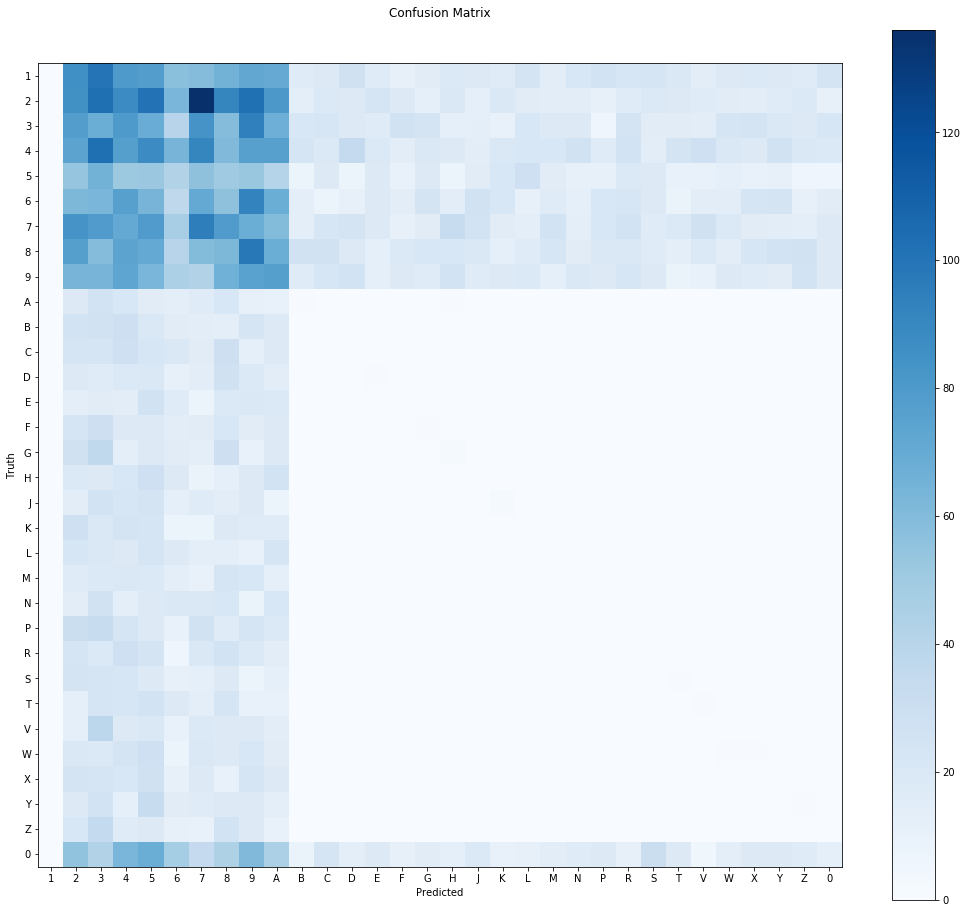

/home/christina/Documents/Thesis/AutomaticLP


In [1]:
%matplotlib inline
%cd tf_object_detection_cm
%run confusion_matrix.py --detections_record=../TFExamples.tfrecord --label_map=../FromScratch/data/label_map.pbtxt --output_path=confusion_matrix.csv
%cd ..